# Laboratorium 3 - Badanie modelu sieci neuronowej
## Jakub Czajkowski 272709

## Cel eksperymentów

Zbadanie wpływu różnych hiperparametrów na zachowanie modelu sieci neuronowej dla zbioru **heart disease**:

1. **Różna wymiarowość warstwy ukrytej** - testowanie [4, 8, 16, 32, 64, 128, 256, 512] neuronów
2. **Różna wartość współczynnika uczenia** - testowanie [0.001, 0.005, 0.01, 0.05, 0.1, 0.5]
3. **Różne odchylenia standardowe przy inicjalizacji wag** - testowanie [0.001, 0.01, 0.1, 0.5, 1.0]
4. **Dane znormalizowane vs nieznormalizowane** - porównanie wpływu normalizacji
5. **Różna liczba warstw** - testowanie [1, 2, 3, 4] warstw ukrytych

---

In [133]:
# Przygotowanie danych znormalizowanych i nieznormalizowanych
import pickle
import numpy as np
from sklearn.model_selection import train_test_split

# Wczytanie danych
with open('data.pkl', 'rb') as f:
    X_matrix, y = pickle.load(f)

y = y['num'].apply(lambda v: 1 if v > 0 else 0)

seed = 14

# Podział na train/test
X_train_raw, X_test_raw, y_train, y_test = train_test_split(
    X_matrix, y, test_size=0.2, stratify=y, random_state=seed
)

# Konwersja do numpy
X_train_raw = np.asarray(X_train_raw, dtype=np.float64)
X_test_raw = np.asarray(X_test_raw, dtype=np.float64)
y_train = np.asarray(y_train, dtype=np.float64).reshape(-1, 1)
y_test = np.asarray(y_test, dtype=np.float64).reshape(-1, 1)

# Normalizacja danych
train_mean = X_train_raw.mean(axis=0)
train_std = X_train_raw.std(axis=0, ddof=0)
train_std[train_std == 0] = 1.0

X_train_norm = (X_train_raw - train_mean) / train_std
X_test_norm = (X_test_raw - train_mean) / train_std

print(f"Dataset shape: {X_train_raw.shape}")
print(f"Number of features: {X_train_raw.shape[1]}")
print(f"Train samples: {X_train_raw.shape[0]}, Test samples: {X_test_raw.shape[0]}")

Dataset shape: (242, 25)
Number of features: 25
Train samples: 242, Test samples: 61


In [134]:
class FunctionInterface:
    def forward(self, x):
        pass

    def backward(self, x):
        pass

class Sigmoid(FunctionInterface):
    def forward(self, x):
        return 1 / (1 + np.exp(-x))

    def backward(self, x):
        sig = self.forward(x)
        return sig * (1 - sig)
    
class ReLU(FunctionInterface):
    def forward(self, x):
        return np.maximum(0, x)

    def backward(self, x):
        grad = np.zeros_like(x)
        grad[x > 0] = 1.0
        return grad

In [135]:
class Layer:
    def __init__(self, input_size, output_size, activation_function, init_std=0.01):
        self.input_size = input_size
        self.output_size = output_size
        self.activation_function = activation_function

        # Inicjalizacja wag i biasów
        self.weights = np.random.randn(input_size, output_size) * init_std
        self.biases = np.zeros((1, output_size))

        # Cache
        self.inputs = None
        self.z = None
        self.a = None

    def forward(self, inputs):
        self.inputs = inputs
        self.z = np.dot(inputs, self.weights) + self.biases
        self.a = self.activation_function.forward(self.z)
        return self.a
    
    def backward(self, dL_da, learning_rate):
        m = self.inputs.shape[0]

        # pochodna z aktywacji
        dL_dz = dL_da * self.activation_function.backward(self.z)

        # pochodne wag i biasów
        dW = np.dot(self.inputs.T, dL_dz) / m
        db = np.sum(dL_dz, axis=0, keepdims=True) / m

        # pochodna względem wejścia (dla poprzedniej warstwy)
        dL_dinputs = np.dot(dL_dz, self.weights.T)

        # aktualizacja wag
        self.weights -= learning_rate * dW
        self.biases -= learning_rate * db

        return dL_dinputs

In [136]:
class BinaryCrossEntropy:
    """
    Średnia binarna entropia krzyżowa (BCE).
    Uwaga: backward NIE dzieli przez m, aby uniknąć podwójnego uśredniania,
    bo Layer.backward już dzieli przy liczeniu dW/db.
    """
    def __init__(self, eps: float = 1e-12):
        self.eps = eps

    def forward(self, y_true, y_pred):
        y_pred = np.clip(y_pred, self.eps, 1.0 - self.eps)
        loss = - (y_true * np.log(y_pred) + (1 - y_true) * np.log(1 - y_pred))
        return np.mean(loss)

    def backward(self, y_true, y_pred):
        y_pred = np.clip(y_pred, self.eps, 1.0 - self.eps)
        # dL/da dla BCE: -(y/a) + (1-y)/(1-a)
        return -(y_true / y_pred) + ((1 - y_true) / (1 - y_pred))

In [137]:
# Prosty wrapper sieci neuronowej do łączenia warstw
class NeuralNetwork:
    def __init__(self, layers):
        self.layers = layers

    def forward(self, X):
        out = X
        for layer in self.layers:
            out = layer.forward(out)
        return out

    def backward(self, dL_da, learning_rate):
        grad = dL_da
        for layer in reversed(self.layers):
            grad = layer.backward(grad, learning_rate)
        return grad

    def predict_proba(self, X):
        return self.forward(X)

    def predict(self, X, threshold=0.5):
        probs = self.predict_proba(X)
        return (probs >= threshold).astype(np.float64)

    def fit(self, X, y, loss_fn, epochs=200, learning_rate=0.1, verbose=True):
        losses = []
        for epoch in range(1, epochs + 1):
            # Forward
            y_pred = self.forward(X)
            loss = loss_fn.forward(y, y_pred)
            losses.append(loss)

            # Backward
            dL_da = loss_fn.backward(y, y_pred)
            self.backward(dL_da, learning_rate)

            if verbose and (epoch % max(1, (epochs // 10)) == 0 or epoch == 1):
                print(f"Epoch {epoch:4d}/{epochs} | loss={loss:.6f}")


# Badanie wpływu różnych parametrów na model

Przeprowadzimy eksperymenty badające wpływ:
1. Różnej wymiarowości warstwy ukrytej
2. Różnej wartości współczynnika uczenia
3. Różnych odchyleń standardowych przy inicjalizacji wag
4. Danych znormalizowanych i nieznormalizowanych
5. Różnej liczby warstw

In [138]:
# Funkcja do trenowania i ewaluacji modelu
from sklearn.metrics import accuracy_score, precision_score, recall_score, f1_score, roc_auc_score

def train_and_evaluate(model, X_train, y_train, X_test, y_test, epochs=1000, learning_rate=0.01, verbose=False):
    """
    Trenuje model i zwraca wyniki.
    """
    loss_fn = BinaryCrossEntropy()
    
    # Trenowanie
    model.fit(X_train, y_train, loss_fn=loss_fn, epochs=epochs, learning_rate=learning_rate, verbose=verbose)
    
    # Ewaluacja
    train_preds = model.predict(X_train)
    train_acc = accuracy_score(y_train, train_preds)
    
    test_preds = model.predict(X_test)
    test_acc = accuracy_score(y_test, test_preds)
    
    return train_acc, test_acc


def calculate_all_metrics(model, X_train, y_train, X_test, y_test):
    """
    Oblicza wszystkie metryki dla wytrenowanego modelu.
    
    Returns:
        dict: słownik z metrykami (train_acc, test_acc, precision, recall, f1_score, auc_roc)
    """
    # Accuracy
    train_preds = model.predict(X_train)
    train_acc = accuracy_score(y_train, train_preds)
    
    test_preds = model.predict(X_test)
    test_acc = accuracy_score(y_test, test_preds)
    
    # Pozostałe metryki (na zbiorze testowym)
    test_proba = model.forward(X_test)
    
    precision = precision_score(y_test, test_preds)
    recall = recall_score(y_test, test_preds)
    f1 = f1_score(y_test, test_preds)
    roc_auc = roc_auc_score(y_test, test_proba)
    
    return {
        'train_acc': train_acc,
        'test_acc': test_acc,
        'precision': precision,
        'recall': recall,
        'f1_score': f1,
        'auc_roc': roc_auc
    }

In [139]:
# Funkcje do wizualizacji wyników
import matplotlib.pyplot as plt
from sklearn.metrics import roc_curve, auc, confusion_matrix, ConfusionMatrixDisplay
from sklearn.metrics import precision_score, recall_score, f1_score, roc_auc_score

def plot_metrics_grid(stats_df, x_column, title_prefix, x_label, use_log_scale=False, log_base=None):
    """
    Tworzy siatkę 2x2 wykresów z metrykami: Accuracy, F1, Precision/Recall, AUC-ROC
    
    Args:
        stats_df: DataFrame z wynikami
        x_column: nazwa kolumny z wartościami osi X
        title_prefix: prefiks dla tytułów wykresów
        x_label: etykieta osi X
        use_log_scale: czy użyć skali logarytmicznej
        log_base: podstawa logarytmu (domyślnie None)
    """
    fig, axes = plt.subplots(2, 2, figsize=(16, 12))
    
    # Accuracy
    ax = axes[0, 0]
    ax.plot(stats_df[x_column], stats_df['train_acc'], 'o-', label='Train Accuracy', linewidth=2)
    ax.plot(stats_df[x_column], stats_df['test_acc'], 's-', label='Test Accuracy', linewidth=2)
    ax.set_xlabel(x_label, fontsize=12)
    ax.set_ylabel('Accuracy', fontsize=12)
    ax.set_title(f'{title_prefix} na dokładność', fontsize=14)
    ax.legend(fontsize=11)
    ax.grid(True, alpha=0.3)
    if use_log_scale:
        if log_base:
            ax.set_xscale('log', base=log_base)
        else:
            ax.set_xscale('log')
    
    # F1 Score
    ax = axes[0, 1]
    ax.plot(stats_df[x_column], stats_df['f1_score'], 'o-', color='green', linewidth=2)
    ax.set_xlabel(x_label, fontsize=12)
    ax.set_ylabel('F1 Score', fontsize=12)
    ax.set_title(f'{title_prefix} na F1 Score', fontsize=14)
    ax.grid(True, alpha=0.3)
    if use_log_scale:
        if log_base:
            ax.set_xscale('log', base=log_base)
        else:
            ax.set_xscale('log')
    
    # Precision and Recall
    ax = axes[1, 0]
    ax.plot(stats_df[x_column], stats_df['precision'], 'o-', label='Precision', linewidth=2, color='blue')
    ax.plot(stats_df[x_column], stats_df['recall'], 's-', label='Recall', linewidth=2, color='red')
    ax.set_xlabel(x_label, fontsize=12)
    ax.set_ylabel('Score', fontsize=12)
    ax.set_title(f'{title_prefix} na Precision i Recall', fontsize=14)
    ax.legend(fontsize=11)
    ax.grid(True, alpha=0.3)
    if use_log_scale:
        if log_base:
            ax.set_xscale('log', base=log_base)
        else:
            ax.set_xscale('log')
    
    # AUC-ROC
    ax = axes[1, 1]
    ax.plot(stats_df[x_column], stats_df['auc_roc'], 'o-', color='purple', linewidth=2)
    ax.set_xlabel(x_label, fontsize=12)
    ax.set_ylabel('AUC-ROC', fontsize=12)
    ax.set_title(f'{title_prefix} na AUC-ROC', fontsize=14)
    ax.grid(True, alpha=0.3)
    if use_log_scale:
        if log_base:
            ax.set_xscale('log', base=log_base)
        else:
            ax.set_xscale('log')
    
    plt.tight_layout()
    plt.show()


def plot_metrics_bar(stats_df, category_column, title_prefix, x_label):
    """
    Tworzy siatkę 2x2 wykresów słupkowych z metrykami dla kategorii
    
    Args:
        stats_df: DataFrame z wynikami
        category_column: nazwa kolumny z kategoriami
        title_prefix: prefiks dla tytułów wykresów
        x_label: etykieta osi X
    """
    fig, axes = plt.subplots(2, 2, figsize=(16, 12))
    x = np.arange(len(stats_df))
    width = 0.35
    
    # Accuracy
    ax = axes[0, 0]
    bars1 = ax.bar(x - width/2, stats_df['train_acc'], width, label='Train Accuracy', alpha=0.8)
    bars2 = ax.bar(x + width/2, stats_df['test_acc'], width, label='Test Accuracy', alpha=0.8)
    ax.set_xlabel(x_label, fontsize=12)
    ax.set_ylabel('Accuracy', fontsize=12)
    ax.set_title(f'{title_prefix} na dokładność', fontsize=14)
    ax.set_xticks(x)
    ax.set_xticklabels(stats_df[category_column])
    ax.legend(fontsize=11)
    ax.grid(True, alpha=0.3, axis='y')
    ax.set_ylim([0, 1])
    for bars in [bars1, bars2]:
        for bar in bars:
            height = bar.get_height()
            ax.text(bar.get_x() + bar.get_width()/2., height,
                    f'{height:.3f}', ha='center', va='bottom', fontsize=10)
    
    # F1 Score
    ax = axes[0, 1]
    bars = ax.bar(x, stats_df['f1_score'], width*2, alpha=0.8, color='green')
    ax.set_xlabel(x_label, fontsize=12)
    ax.set_ylabel('F1 Score', fontsize=12)
    ax.set_title(f'{title_prefix} na F1 Score', fontsize=14)
    ax.set_xticks(x)
    ax.set_xticklabels(stats_df[category_column])
    ax.grid(True, alpha=0.3, axis='y')
    ax.set_ylim([0, 1])
    for bar in bars:
        height = bar.get_height()
        ax.text(bar.get_x() + bar.get_width()/2., height,
                f'{height:.3f}', ha='center', va='bottom', fontsize=10)
    
    # Precision and Recall
    ax = axes[1, 0]
    bars1 = ax.bar(x - width/2, stats_df['precision'], width, label='Precision', alpha=0.8, color='blue')
    bars2 = ax.bar(x + width/2, stats_df['recall'], width, label='Recall', alpha=0.8, color='red')
    ax.set_xlabel(x_label, fontsize=12)
    ax.set_ylabel('Score', fontsize=12)
    ax.set_title(f'{title_prefix} na Precision i Recall', fontsize=14)
    ax.set_xticks(x)
    ax.set_xticklabels(stats_df[category_column])
    ax.legend(fontsize=11)
    ax.grid(True, alpha=0.3, axis='y')
    ax.set_ylim([0, 1])
    for bars in [bars1, bars2]:
        for bar in bars:
            height = bar.get_height()
            ax.text(bar.get_x() + bar.get_width()/2., height,
                    f'{height:.3f}', ha='center', va='bottom', fontsize=10)
    
    # AUC-ROC
    ax = axes[1, 1]
    bars = ax.bar(x, stats_df['auc_roc'], width*2, alpha=0.8, color='purple')
    ax.set_xlabel(x_label, fontsize=12)
    ax.set_ylabel('AUC-ROC', fontsize=12)
    ax.set_title(f'{title_prefix} na AUC-ROC', fontsize=14)
    ax.set_xticks(x)
    ax.set_xticklabels(stats_df[category_column])
    ax.grid(True, alpha=0.3, axis='y')
    ax.set_ylim([0, 1])
    for bar in bars:
        height = bar.get_height()
        ax.text(bar.get_x() + bar.get_width()/2., height,
                f'{height:.3f}', ha='center', va='bottom', fontsize=10)
    
    plt.tight_layout()
    plt.show()


def plot_confusion_matrix_and_roc(y_test, test_proba, test_preds, title, config_text):
    """
    Tworzy wykres ROC curve i confusion matrix obok siebie
    
    Args:
        y_test: prawdziwe etykiety
        test_proba: prawdopodobieństwa predykcji
        test_preds: binarne predykcje
        title: tytuł dla wykresów
        config_text: tekst z konfiguracją modelu
    """
    # Oblicz metryki
    precision = precision_score(y_test, test_preds)
    recall = recall_score(y_test, test_preds)
    f1 = f1_score(y_test, test_preds)
    roc_auc = roc_auc_score(y_test, test_proba)
    
    # ROC curve
    fpr, tpr, _ = roc_curve(y_test, test_proba)
    
    # Confusion Matrix
    cm = confusion_matrix(y_test, test_preds)
    
    # Wizualizacja
    fig, (ax1, ax2) = plt.subplots(1, 2, figsize=(14, 5))
    
    # ROC curve
    ax1.plot(fpr, tpr, color='darkorange', lw=2, label=f'ROC curve (AUC = {roc_auc:.3f})')
    ax1.plot([0, 1], [0, 1], color='navy', lw=2, linestyle='--', label='Random')
    ax1.set_xlabel('False Positive Rate', fontsize=12)
    ax1.set_ylabel('True Positive Rate', fontsize=12)
    ax1.set_title(f'ROC Curve - {title}', fontsize=14)
    ax1.legend(loc='lower right', fontsize=11)
    ax1.grid(True, alpha=0.3)
    
    # Confusion matrix
    disp = ConfusionMatrixDisplay(confusion_matrix=cm, display_labels=['No Disease', 'Disease'])
    disp.plot(ax=ax2, cmap='Blues', values_format='d')
    ax2.set_title(f'Confusion Matrix - {title}', fontsize=14)
    
    plt.tight_layout()
    plt.show()
    
    # Print metrics
    print(f"\nBest configuration: {config_text}")
    print(f"Precision: {precision:.4f}")
    print(f"Recall: {recall:.4f}")
    print(f"F1-Score: {f1:.4f}")
    print(f"AUC-ROC: {roc_auc:.4f}")
    print(f"\nConfusion Matrix:\n{cm}")
    
    return precision, recall, f1, roc_auc, cm


def plot_comparison_roc_and_cm(models_data, y_test):
    """
    Tworzy porównanie ROC curve i confusion matrix dla wielu modeli w jednym wykresie
    
    Args:
        models_data: lista słowników z kluczami:
            - 'model': wytrenowany model
            - 'X_test': dane testowe
            - 'label': etykieta dla wykresu
        y_test: prawdziwe etykiety testowe
    """
    n_models = len(models_data)
    fig, axes = plt.subplots(n_models, 2, figsize=(14, 5 * n_models))
    
    # Jeśli tylko jeden model, axes nie będzie dwuwymiarowe
    if n_models == 1:
        axes = axes.reshape(1, -1)
    
    for i, data in enumerate(models_data):
        model = data['model']
        X_test = data['X_test']
        label = data['label']
        
        # Predykcje
        test_proba = model.forward(X_test)
        test_preds = (test_proba > 0.5).astype(int)
        
        # Metrics
        precision = precision_score(y_test, test_preds)
        recall = recall_score(y_test, test_preds)
        f1 = f1_score(y_test, test_preds)
        roc_auc = roc_auc_score(y_test, test_proba)
        
        # ROC-AUC
        fpr, tpr, _ = roc_curve(y_test, test_proba)
        
        # Confusion Matrix
        cm = confusion_matrix(y_test, test_preds)
        
        # ROC curve
        ax1 = axes[i, 0]
        ax1.plot(fpr, tpr, color='darkorange', lw=2, label=f'ROC curve (AUC = {roc_auc:.3f})')
        ax1.plot([0, 1], [0, 1], color='navy', lw=2, linestyle='--', label='Random')
        ax1.set_xlabel('False Positive Rate', fontsize=12)
        ax1.set_ylabel('True Positive Rate', fontsize=12)
        ax1.set_title(f'ROC Curve - {label}', fontsize=14)
        ax1.legend(loc='lower right', fontsize=11)
        ax1.grid(True, alpha=0.3)
        
        # Confusion matrix
        ax2 = axes[i, 1]
        disp = ConfusionMatrixDisplay(confusion_matrix=cm, display_labels=['No Disease', 'Disease'])
        disp.plot(ax=ax2, cmap='Blues', values_format='d')
        ax2.set_title(f'Confusion Matrix - {label}', fontsize=14)
        
        print(f"\n{label}:")
        print(f"Precision: {precision:.4f}")
        print(f"Recall: {recall:.4f}")
        print(f"F1-Score: {f1:.4f}")
        print(f"AUC-ROC: {roc_auc:.4f}")
        print(f"Confusion Matrix:\n{cm}")
    
    plt.tight_layout()
    plt.show()

### Dostępne funkcje pomocnicze:

**Funkcje trenowania i ewaluacji:**
- `train_and_evaluate()` - trenuje model i zwraca train/test accuracy
- `calculate_all_metrics()` - oblicza wszystkie metryki dla wytrenowanego modelu

**Funkcje wizualizacji:**
- `plot_metrics_grid()` - tworzy siatkę 2x2 wykresów liniowych (Accuracy, F1, Precision/Recall, AUC-ROC)
- `plot_metrics_bar()` - tworzy siatkę 2x2 wykresów słupkowych (do porównań kategorycznych)
- `plot_confusion_matrix_and_roc()` - wyświetla ROC curve i confusion matrix dla najlepszego modelu
- `plot_comparison_roc_and_cm()` - porównuje wiele modeli na jednym wykresie (ROC + confusion matrix)

## 1. Wpływ wymiarowości warstwy ukrytej

Testujemy różne rozmiary warstwy ukrytej: [4, 8, 16, 32, 64, 128]

In [140]:
import pandas as pd
from sklearn.metrics import precision_score, recall_score, f1_score, roc_auc_score

# Test różnych wymiarów warstwy ukrytej
hidden_dims = [4, 8, 16, 32, 64, 128, 256, 512]
input_dim = X_train_norm.shape[1]

results = []

print("Testing different hidden layer dimensions...")
for hd in hidden_dims:
    np.random.seed(seed)
    
    model = NeuralNetwork([
        Layer(input_dim, hd, ReLU(), init_std=0.01),
        Layer(hd, 1, Sigmoid(), init_std=0.01),
    ])
    
    train_acc, test_acc = train_and_evaluate(
        model, X_train_norm, y_train, X_test_norm, y_test,
        epochs=500, learning_rate=0.01, verbose=False
    )
    
    # Calculate additional metrics
    test_proba = model.forward(X_test_norm)
    test_preds = (test_proba > 0.5).astype(int)
    
    precision = precision_score(y_test, test_preds)
    recall = recall_score(y_test, test_preds)
    f1 = f1_score(y_test, test_preds)
    roc_auc = roc_auc_score(y_test, test_proba)
    
    results.append({
        'hidden_dim': hd,
        'train_acc': train_acc,
        'test_acc': test_acc,
        'precision': precision,
        'recall': recall,
        'f1_score': f1,
        'auc_roc': roc_auc
    })
    
    print(f"Hidden dim: {hd:3d} | Train: {train_acc:.4f} | Test: {test_acc:.4f} | F1: {f1:.4f} | AUC: {roc_auc:.4f}")

hidden_stats = pd.DataFrame(results)
print("\n" + "="*60)
print(hidden_stats.to_string(index=False))

Testing different hidden layer dimensions...
Hidden dim:   4 | Train: 0.5413 | Test: 0.5410 | F1: 0.0000 | AUC: 0.8999
Hidden dim:   8 | Train: 0.5413 | Test: 0.5410 | F1: 0.0000 | AUC: 0.8398
Hidden dim:  16 | Train: 0.5413 | Test: 0.5410 | F1: 0.0000 | AUC: 0.9048
Hidden dim:  32 | Train: 0.7107 | Test: 0.7541 | F1: 0.6341 | AUC: 0.9242


/Users/czaja/PycharmProjects/sieci/venv/lib/python3.13/site-packages/sklearn/metrics/_classification.py:1731: UndefinedMetricWarning: Precision is ill-defined and being set to 0.0 due to no predicted samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, f"{metric.capitalize()} is", result.shape[0])
/Users/czaja/PycharmProjects/sieci/venv/lib/python3.13/site-packages/sklearn/metrics/_classification.py:1731: UndefinedMetricWarning: Precision is ill-defined and being set to 0.0 due to no predicted samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, f"{metric.capitalize()} is", result.shape[0])
/Users/czaja/PycharmProjects/sieci/venv/lib/python3.13/site-packages/sklearn/metrics/_classification.py:1731: UndefinedMetricWarning: Precision is ill-defined and being set to 0.0 due to no predicted samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, f"{metric.capitalize

Hidden dim:  64 | Train: 0.7851 | Test: 0.7869 | F1: 0.7234 | AUC: 0.9210
Hidden dim: 128 | Train: 0.8554 | Test: 0.8525 | F1: 0.8364 | AUC: 0.9297
Hidden dim: 256 | Train: 0.8636 | Test: 0.8525 | F1: 0.8364 | AUC: 0.9264
Hidden dim: 512 | Train: 0.8512 | Test: 0.8361 | F1: 0.8276 | AUC: 0.9297

 hidden_dim  train_acc  test_acc  precision   recall  f1_score  auc_roc
          4   0.541322  0.540984   0.000000 0.000000  0.000000 0.899892
          8   0.541322  0.540984   0.000000 0.000000  0.000000 0.839827
         16   0.541322  0.540984   0.000000 0.000000  0.000000 0.904762
         32   0.710744  0.754098   1.000000 0.464286  0.634146 0.924242
         64   0.785124  0.786885   0.894737 0.607143  0.723404 0.920996
        128   0.855372  0.852459   0.851852 0.821429  0.836364 0.929654
        256   0.863636  0.852459   0.851852 0.821429  0.836364 0.926407
        512   0.851240  0.836066   0.800000 0.857143  0.827586 0.929654


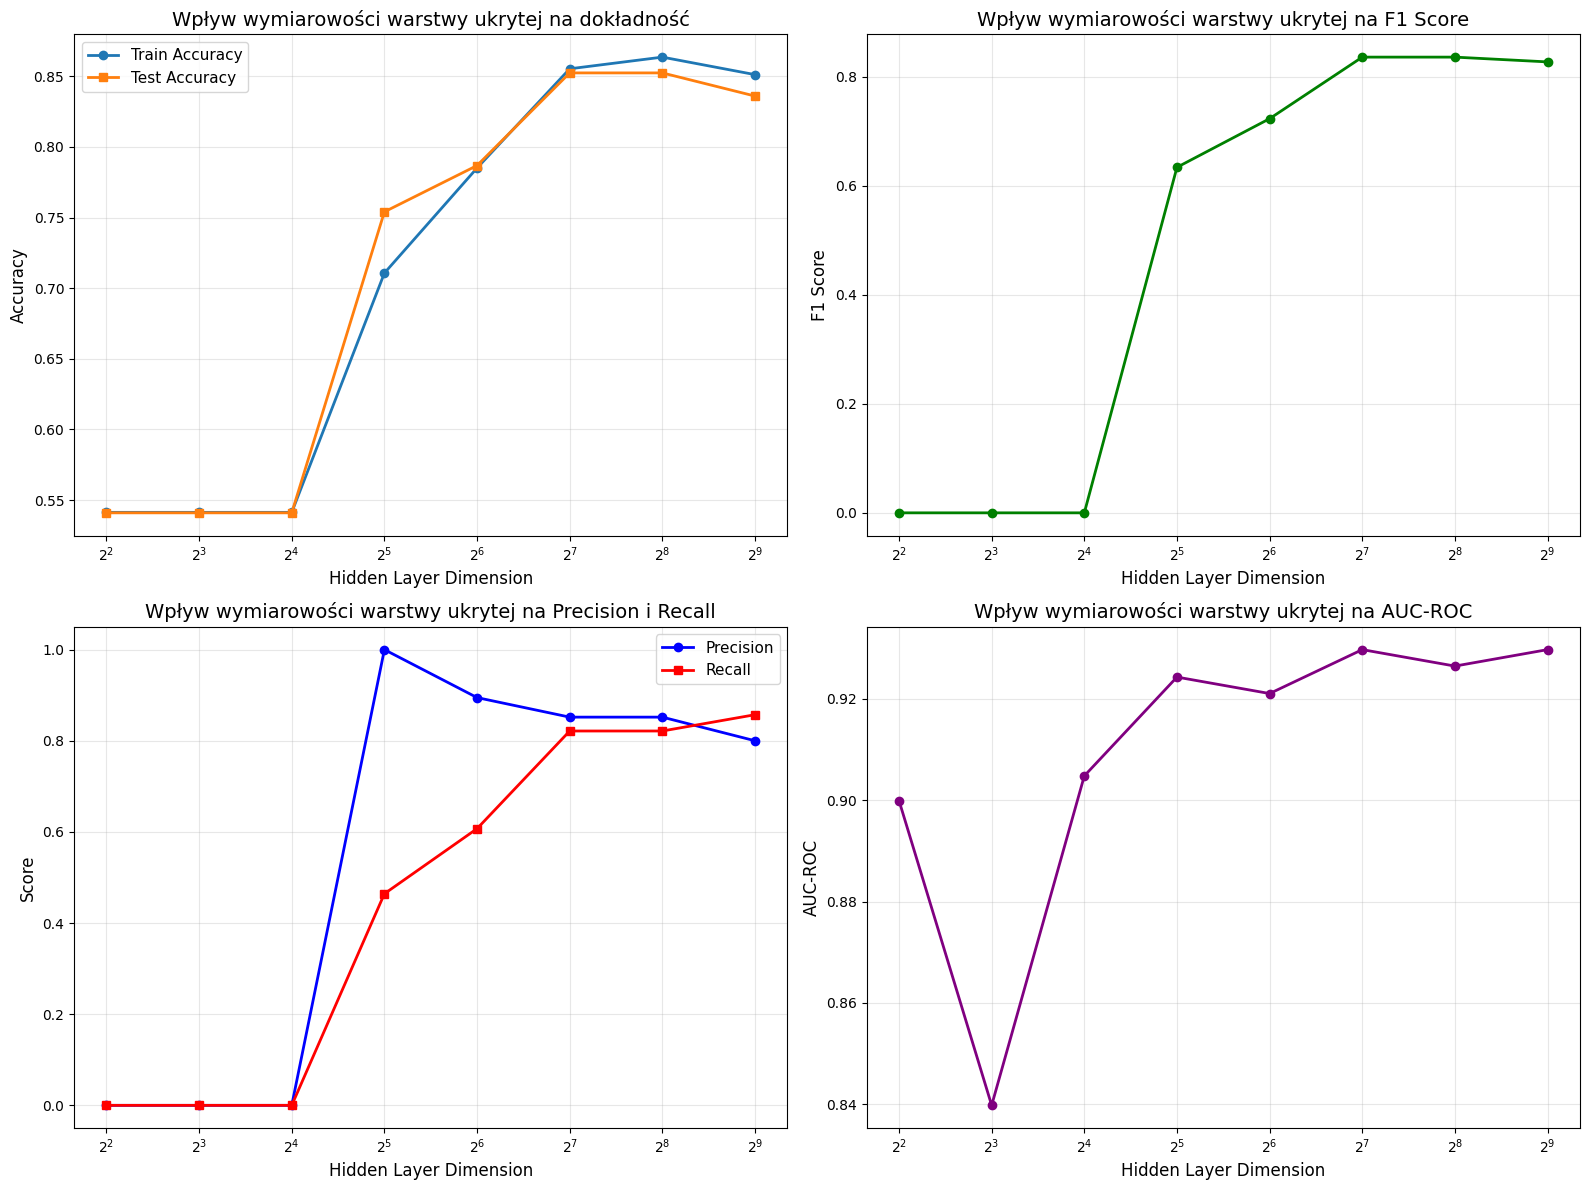

In [141]:
# Wizualizacja wyników dla wymiarowości warstwy ukrytej
plot_metrics_grid(
    hidden_stats, 
    x_column='hidden_dim',
    title_prefix='Wpływ wymiarowości warstwy ukrytej',
    x_label='Hidden Layer Dimension',
    use_log_scale=True,
    log_base=2
)

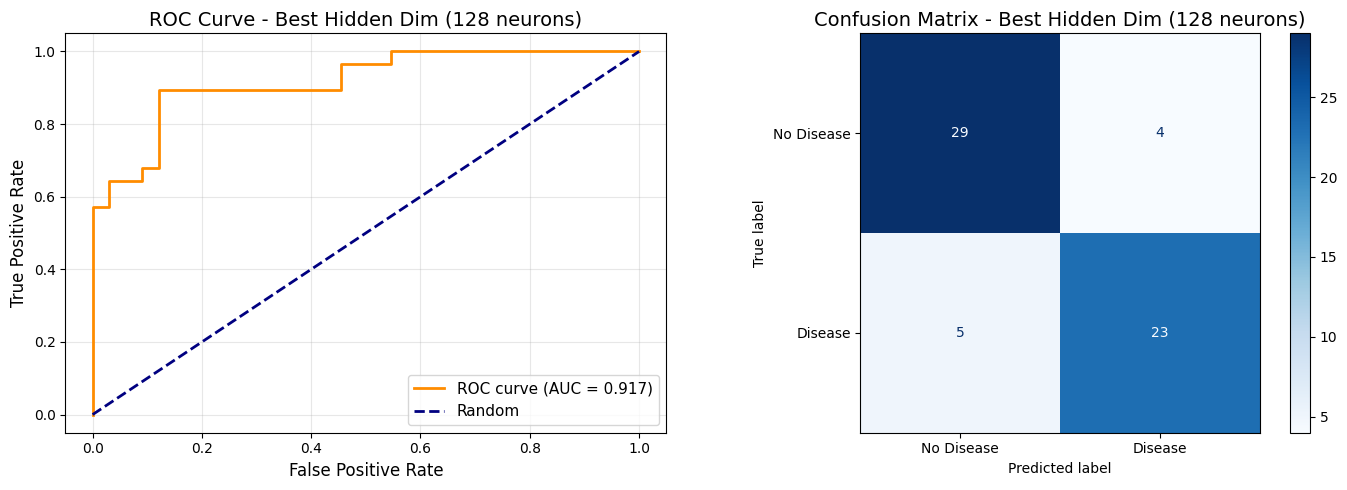


Best configuration: 128 neurons
Precision: 0.8519
Recall: 0.8214
F1-Score: 0.8364
AUC-ROC: 0.9167

Confusion Matrix:
[[29  4]
 [ 5 23]]


(0.8518518518518519,
 0.8214285714285714,
 0.8363636363636363,
 0.9166666666666667,
 array([[29,  4],
        [ 5, 23]]))

In [142]:
# Confusion Matrix dla najlepszego modelu w sekcji 1
# Znajdź najlepszy model z sekcji 1
best_idx = hidden_stats['test_acc'].idxmax()
best_hidden = hidden_stats.loc[best_idx, 'hidden_dim']

# Trenuj najlepszy model ponownie
np.random.seed(seed)
model = NeuralNetwork([
    Layer(input_dim, int(best_hidden), ReLU(), init_std=0.01),
    Layer(int(best_hidden), 1, Sigmoid(), init_std=0.01),
])
train_and_evaluate(model, X_train_norm, y_train, X_test_norm, y_test, epochs=2000, learning_rate=0.01, verbose=False)

# Predykcje
test_proba = model.forward(X_test_norm)
test_preds = (test_proba > 0.5).astype(int)

# Wizualizacja i metryki
plot_confusion_matrix_and_roc(
    y_test, test_proba, test_preds,
    title=f'Best Hidden Dim ({int(best_hidden)} neurons)',
    config_text=f'{int(best_hidden)} neurons'
)

## 2. Wpływ współczynnika uczenia (learning rate)

Testujemy różne wartości learning rate: [0.001, 0.005, 0.01, 0.05, 0.1, 0.5]

In [143]:
# Test różnych wartości learning rate
learning_rates = [0.001, 0.005, 0.01, 0.05, 0.1, 0.5]

results = []

print("Testing different learning rates...")
for lr in learning_rates:
    np.random.seed(seed)
    
    model = NeuralNetwork([
        Layer(input_dim, 32, ReLU(), init_std=0.01),
        Layer(32, 1, Sigmoid(), init_std=0.01),
    ])
    
    train_acc, test_acc = train_and_evaluate(
        model, X_train_norm, y_train, X_test_norm, y_test,
        epochs=2000, learning_rate=lr, verbose=False
    )
    
    # Calculate additional metrics
    test_proba = model.forward(X_test_norm)
    test_preds = (test_proba > 0.5).astype(int)
    
    precision = precision_score(y_test, test_preds)
    recall = recall_score(y_test, test_preds)
    f1 = f1_score(y_test, test_preds)
    roc_auc = roc_auc_score(y_test, test_proba)
    
    results.append({
        'learning_rate': lr,
        'train_acc': train_acc,
        'test_acc': test_acc,
        'precision': precision,
        'recall': recall,
        'f1_score': f1,
        'auc_roc': roc_auc
    })
    
    print(f"LR: {lr:.4f} | Train: {train_acc:.4f} | Test: {test_acc:.4f} | F1: {f1:.4f} | AUC: {roc_auc:.4f}")

lr_stats = pd.DataFrame(results)
print("\n" + "="*60)
print(lr_stats.to_string(index=False))

Testing different learning rates...


/Users/czaja/PycharmProjects/sieci/venv/lib/python3.13/site-packages/sklearn/metrics/_classification.py:1731: UndefinedMetricWarning: Precision is ill-defined and being set to 0.0 due to no predicted samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, f"{metric.capitalize()} is", result.shape[0])


LR: 0.0010 | Train: 0.5413 | Test: 0.5410 | F1: 0.0000 | AUC: 0.9210
LR: 0.0050 | Train: 0.8554 | Test: 0.8361 | F1: 0.8276 | AUC: 0.9275
LR: 0.0100 | Train: 0.8802 | Test: 0.8525 | F1: 0.8364 | AUC: 0.9156
LR: 0.0500 | Train: 0.9504 | Test: 0.7869 | F1: 0.7636 | AUC: 0.8874
LR: 0.1000 | Train: 0.9793 | Test: 0.7377 | F1: 0.7241 | AUC: 0.8701
LR: 0.5000 | Train: 1.0000 | Test: 0.7705 | F1: 0.7500 | AUC: 0.8755

 learning_rate  train_acc  test_acc  precision   recall  f1_score  auc_roc
         0.001   0.541322  0.540984   0.000000 0.000000  0.000000 0.920996
         0.005   0.855372  0.836066   0.800000 0.857143  0.827586 0.927489
         0.010   0.880165  0.852459   0.851852 0.821429  0.836364 0.915584
         0.050   0.950413  0.786885   0.777778 0.750000  0.763636 0.887446
         0.100   0.979339  0.737705   0.700000 0.750000  0.724138 0.870130
         0.500   1.000000  0.770492   0.750000 0.750000  0.750000 0.875541


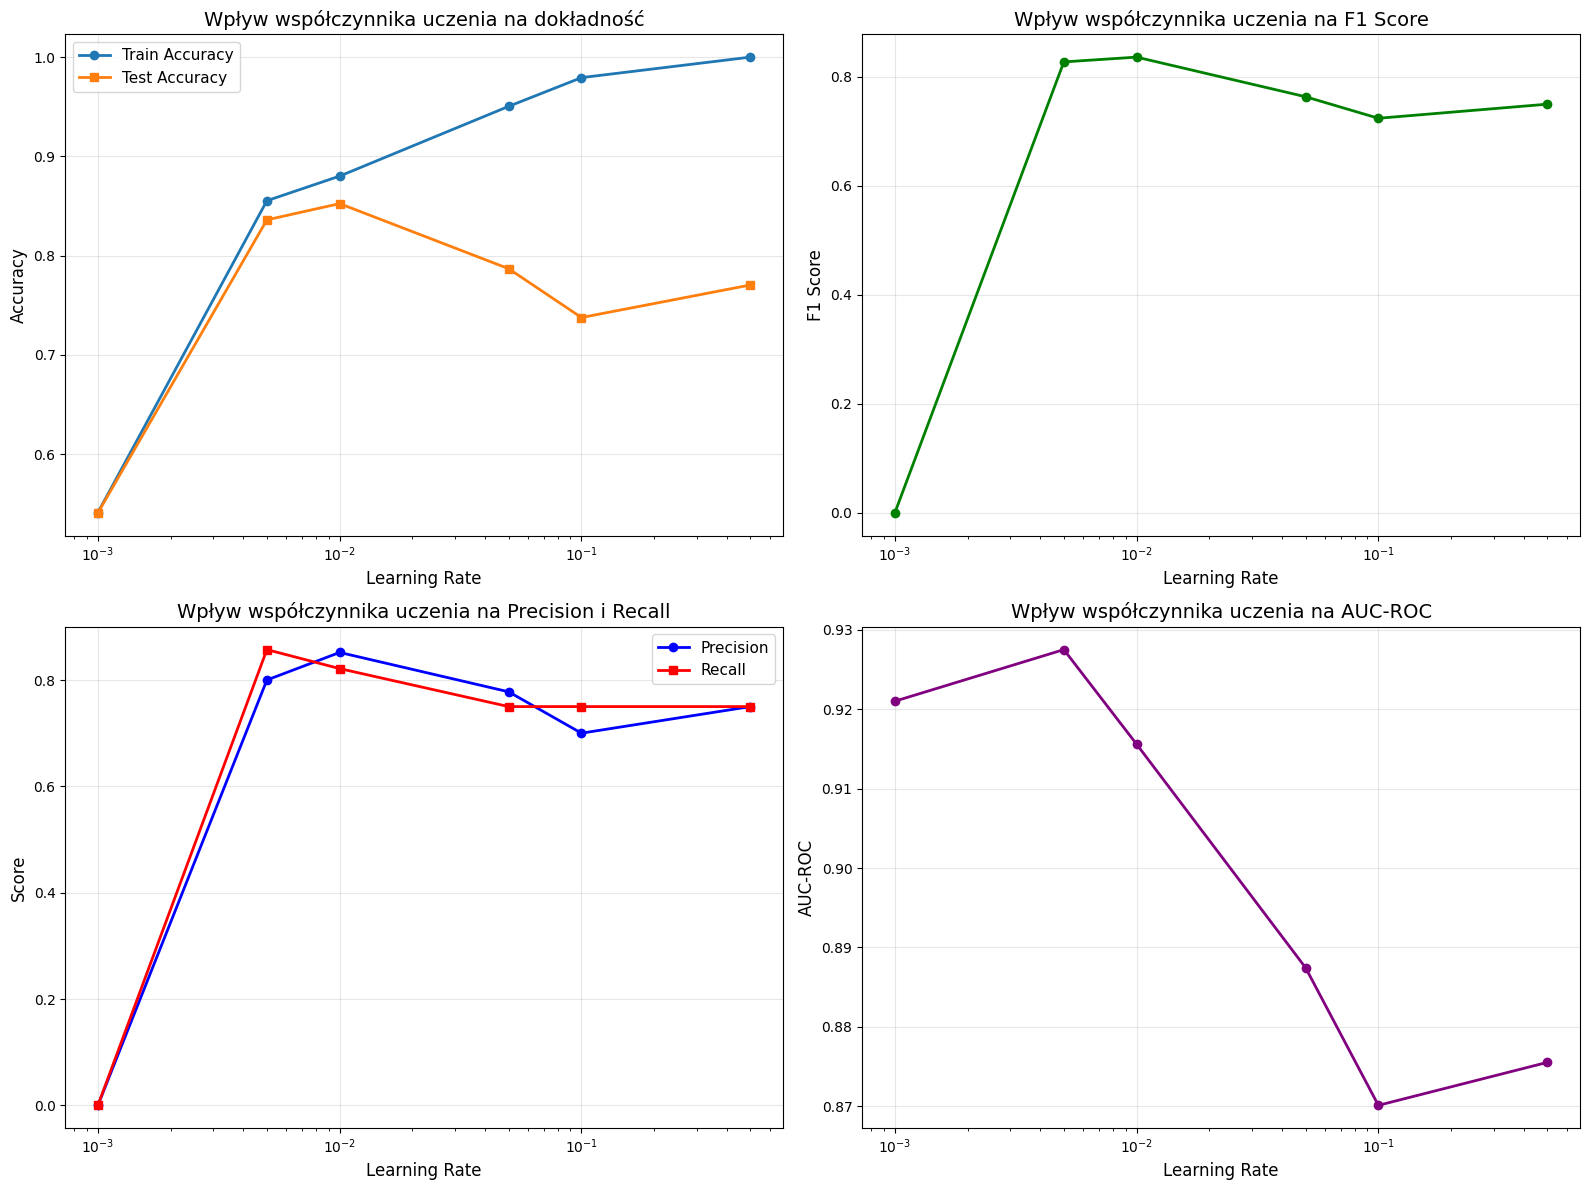

In [144]:
# Wizualizacja wyników dla learning rate
plot_metrics_grid(
    lr_stats,
    x_column='learning_rate',
    title_prefix='Wpływ współczynnika uczenia',
    x_label='Learning Rate',
    use_log_scale=True
)

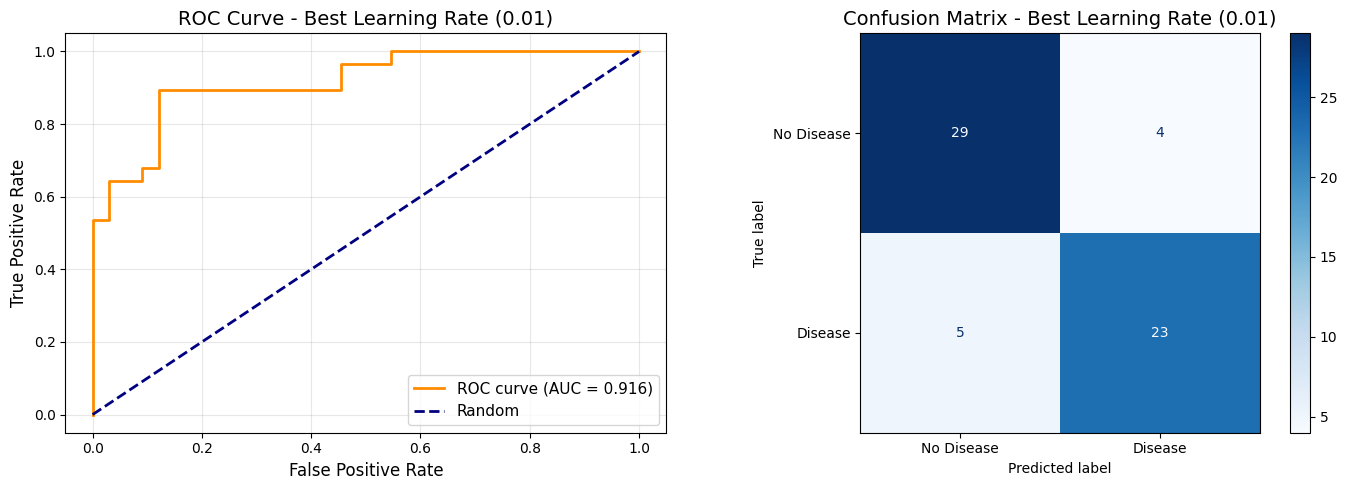


Best configuration: Learning Rate = 0.01
Precision: 0.8519
Recall: 0.8214
F1-Score: 0.8364
AUC-ROC: 0.9156

Confusion Matrix:
[[29  4]
 [ 5 23]]


(0.8518518518518519,
 0.8214285714285714,
 0.8363636363636363,
 0.9155844155844156,
 array([[29,  4],
        [ 5, 23]]))

In [145]:
# Confusion Matrix dla najlepszego modelu w sekcji 2
# Znajdź najlepszy learning rate
best_idx = lr_stats['test_acc'].idxmax()
best_lr = lr_stats.loc[best_idx, 'learning_rate']

# Trenuj najlepszy model ponownie
np.random.seed(seed)
model = NeuralNetwork([
    Layer(input_dim, 32, ReLU(), init_std=0.01),
    Layer(32, 1, Sigmoid(), init_std=0.01),
])
train_and_evaluate(model, X_train_norm, y_train, X_test_norm, y_test, epochs=2000, learning_rate=best_lr, verbose=False)

# Predykcje
test_proba = model.forward(X_test_norm)
test_preds = (test_proba > 0.5).astype(int)

# Wizualizacja i metryki
plot_confusion_matrix_and_roc(
    y_test, test_proba, test_preds,
    title=f'Best Learning Rate ({best_lr})',
    config_text=f'Learning Rate = {best_lr}'
)

## 3. Wpływ odchylenia standardowego przy inicjalizacji wag

Testujemy różne wartości std dla inicjalizacji: [0.001, 0.01, 0.1, 0.5, 1.0]

In [146]:
# Test różnych wartości odchylenia standardowego inicjalizacji wag
init_stds = [0.001, 0.01, 0.1, 0.5, 1.0]

results = []

print("Testing different weight initialization standard deviations...")
for std in init_stds:
    np.random.seed(seed)
    
    model = NeuralNetwork([
        Layer(input_dim, 32, ReLU(), init_std=std),
        Layer(32, 1, Sigmoid(), init_std=std),
    ])
    
    train_acc, test_acc = train_and_evaluate(
        model, X_train_norm, y_train, X_test_norm, y_test,
        epochs=2000, learning_rate=0.01, verbose=False
    )
    
    # Calculate additional metrics
    test_proba = model.forward(X_test_norm)
    test_preds = (test_proba > 0.5).astype(int)
    
    precision = precision_score(y_test, test_preds)
    recall = recall_score(y_test, test_preds)
    f1 = f1_score(y_test, test_preds)
    roc_auc = roc_auc_score(y_test, test_proba)
    
    results.append({
        'init_std': std,
        'train_acc': train_acc,
        'test_acc': test_acc,
        'precision': precision,
        'recall': recall,
        'f1_score': f1,
        'auc_roc': roc_auc
    })
    
    print(f"Std: {std:.4f} | Train: {train_acc:.4f} | Test: {test_acc:.4f} | F1: {f1:.4f} | AUC: {roc_auc:.4f}")

std_stats = pd.DataFrame(results)
print("\n" + "="*60)
print(std_stats.to_string(index=False))

Testing different weight initialization standard deviations...
Std: 0.0010 | Train: 0.8678 | Test: 0.8689 | F1: 0.8571 | AUC: 0.9221
Std: 0.0100 | Train: 0.8802 | Test: 0.8525 | F1: 0.8364 | AUC: 0.9156
Std: 0.1000 | Train: 0.9132 | Test: 0.8689 | F1: 0.8621 | AUC: 0.9091
Std: 0.5000 | Train: 0.9298 | Test: 0.8033 | F1: 0.7931 | AUC: 0.8615
Std: 1.0000 | Train: 0.9380 | Test: 0.7377 | F1: 0.7241 | AUC: 0.8030

 init_std  train_acc  test_acc  precision   recall  f1_score  auc_roc
    0.001   0.867769  0.868852   0.857143 0.857143  0.857143 0.922078
    0.010   0.880165  0.852459   0.851852 0.821429  0.836364 0.915584
    0.100   0.913223  0.868852   0.833333 0.892857  0.862069 0.909091
    0.500   0.929752  0.803279   0.766667 0.821429  0.793103 0.861472
    1.000   0.938017  0.737705   0.700000 0.750000  0.724138 0.803030


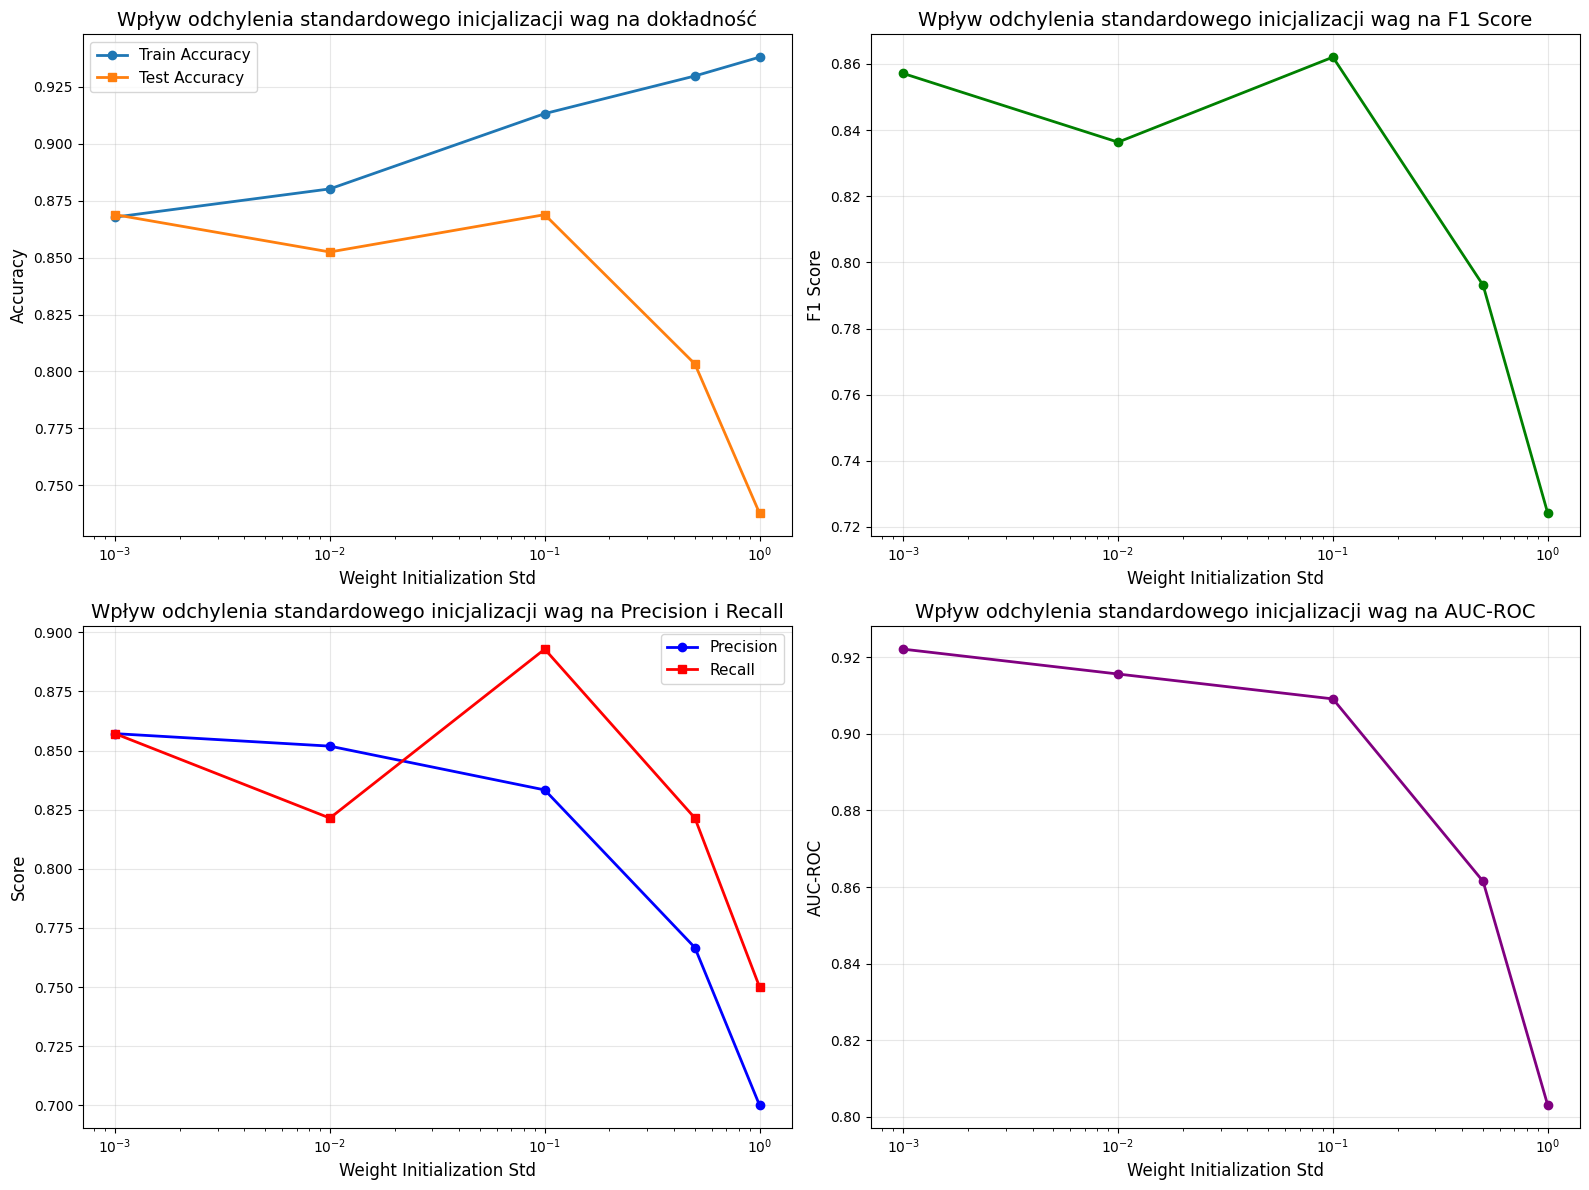

In [147]:
# Wizualizacja wyników dla odchylenia standardowego
plot_metrics_grid(
    std_stats,
    x_column='init_std',
    title_prefix='Wpływ odchylenia standardowego inicjalizacji wag',
    x_label='Weight Initialization Std',
    use_log_scale=True
)

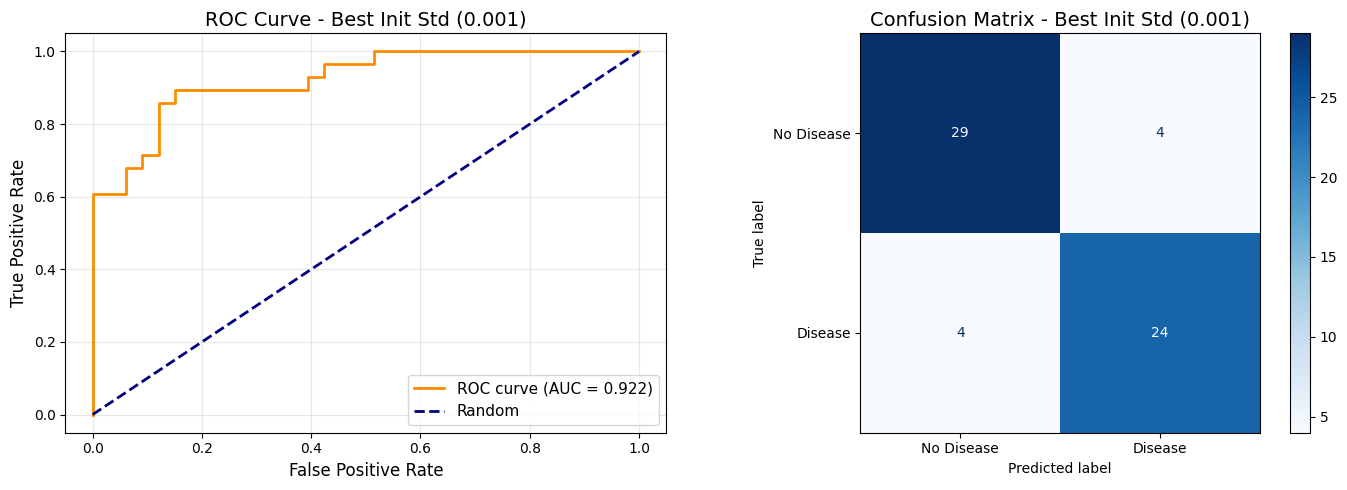


Best configuration: Init Std = 0.001
Precision: 0.8571
Recall: 0.8571
F1-Score: 0.8571
AUC-ROC: 0.9221

Confusion Matrix:
[[29  4]
 [ 4 24]]


(0.8571428571428571,
 0.8571428571428571,
 0.8571428571428571,
 0.922077922077922,
 array([[29,  4],
        [ 4, 24]]))

In [148]:
# Confusion Matrix dla najlepszego modelu w sekcji 3
# Znajdź najlepszy init_std
best_idx = std_stats['test_acc'].idxmax()
best_std = std_stats.loc[best_idx, 'init_std']

# Trenuj najlepszy model ponownie
np.random.seed(seed)
model = NeuralNetwork([
    Layer(input_dim, 32, ReLU(), init_std=best_std),
    Layer(32, 1, Sigmoid(), init_std=best_std),
])
train_and_evaluate(model, X_train_norm, y_train, X_test_norm, y_test, epochs=2000, learning_rate=0.01, verbose=False)

# Predykcje
test_proba = model.forward(X_test_norm)
test_preds = (test_proba > 0.5).astype(int)

# Wizualizacja i metryki
plot_confusion_matrix_and_roc(
    y_test, test_proba, test_preds,
    title=f'Best Init Std ({best_std})',
    config_text=f'Init Std = {best_std}'
)

## 4. Wpływ normalizacji danych

Porównanie wyników dla danych znormalizowanych vs nieznormalizowanych

In [149]:
# Porównanie danych znormalizowanych i nieznormalizowanych
normalize_flags = [False, True]

results = []

print("Testing normalized vs unnormalized data...")
for norm in normalize_flags:
    np.random.seed(seed)
    
    # Wybór odpowiednich danych
    if norm:
        X_train, X_test = X_train_norm, X_test_norm
        label = "Normalized"
    else:
        X_train, X_test = X_train_raw, X_test_raw
        label = "Unnormalized"
    
    model = NeuralNetwork([
        Layer(input_dim, 32, ReLU(), init_std=0.01),
        Layer(32, 1, Sigmoid(), init_std=0.01),
    ])
    
    train_acc, test_acc = train_and_evaluate(
        model, X_train, y_train, X_test, y_test,
        epochs=2000, learning_rate=0.01, verbose=False
    )
    
    # Calculate additional metrics
    test_proba = model.forward(X_test)
    test_preds = (test_proba > 0.5).astype(int)
    
    precision = precision_score(y_test, test_preds)
    recall = recall_score(y_test, test_preds)
    f1 = f1_score(y_test, test_preds)
    roc_auc = roc_auc_score(y_test, test_proba)
    
    results.append({
        'normalized': norm,
        'data_type': label,
        'train_acc': train_acc,
        'test_acc': test_acc,
        'precision': precision,
        'recall': recall,
        'f1_score': f1,
        'auc_roc': roc_auc
    })
    
    print(f"{label:15s} | Train: {train_acc:.4f} | Test: {test_acc:.4f} | F1: {f1:.4f} | AUC: {roc_auc:.4f}")

norm_stats = pd.DataFrame(results)
print("\n" + "="*60)
print(norm_stats.to_string(index=False))

Testing normalized vs unnormalized data...
Unnormalized    | Train: 0.6694 | Test: 0.6393 | F1: 0.5000 | AUC: 0.7976
Normalized      | Train: 0.8802 | Test: 0.8525 | F1: 0.8364 | AUC: 0.9156

 normalized    data_type  train_acc  test_acc  precision   recall  f1_score  auc_roc
      False Unnormalized   0.669421  0.639344   0.687500 0.392857  0.500000 0.797619
       True   Normalized   0.880165  0.852459   0.851852 0.821429  0.836364 0.915584


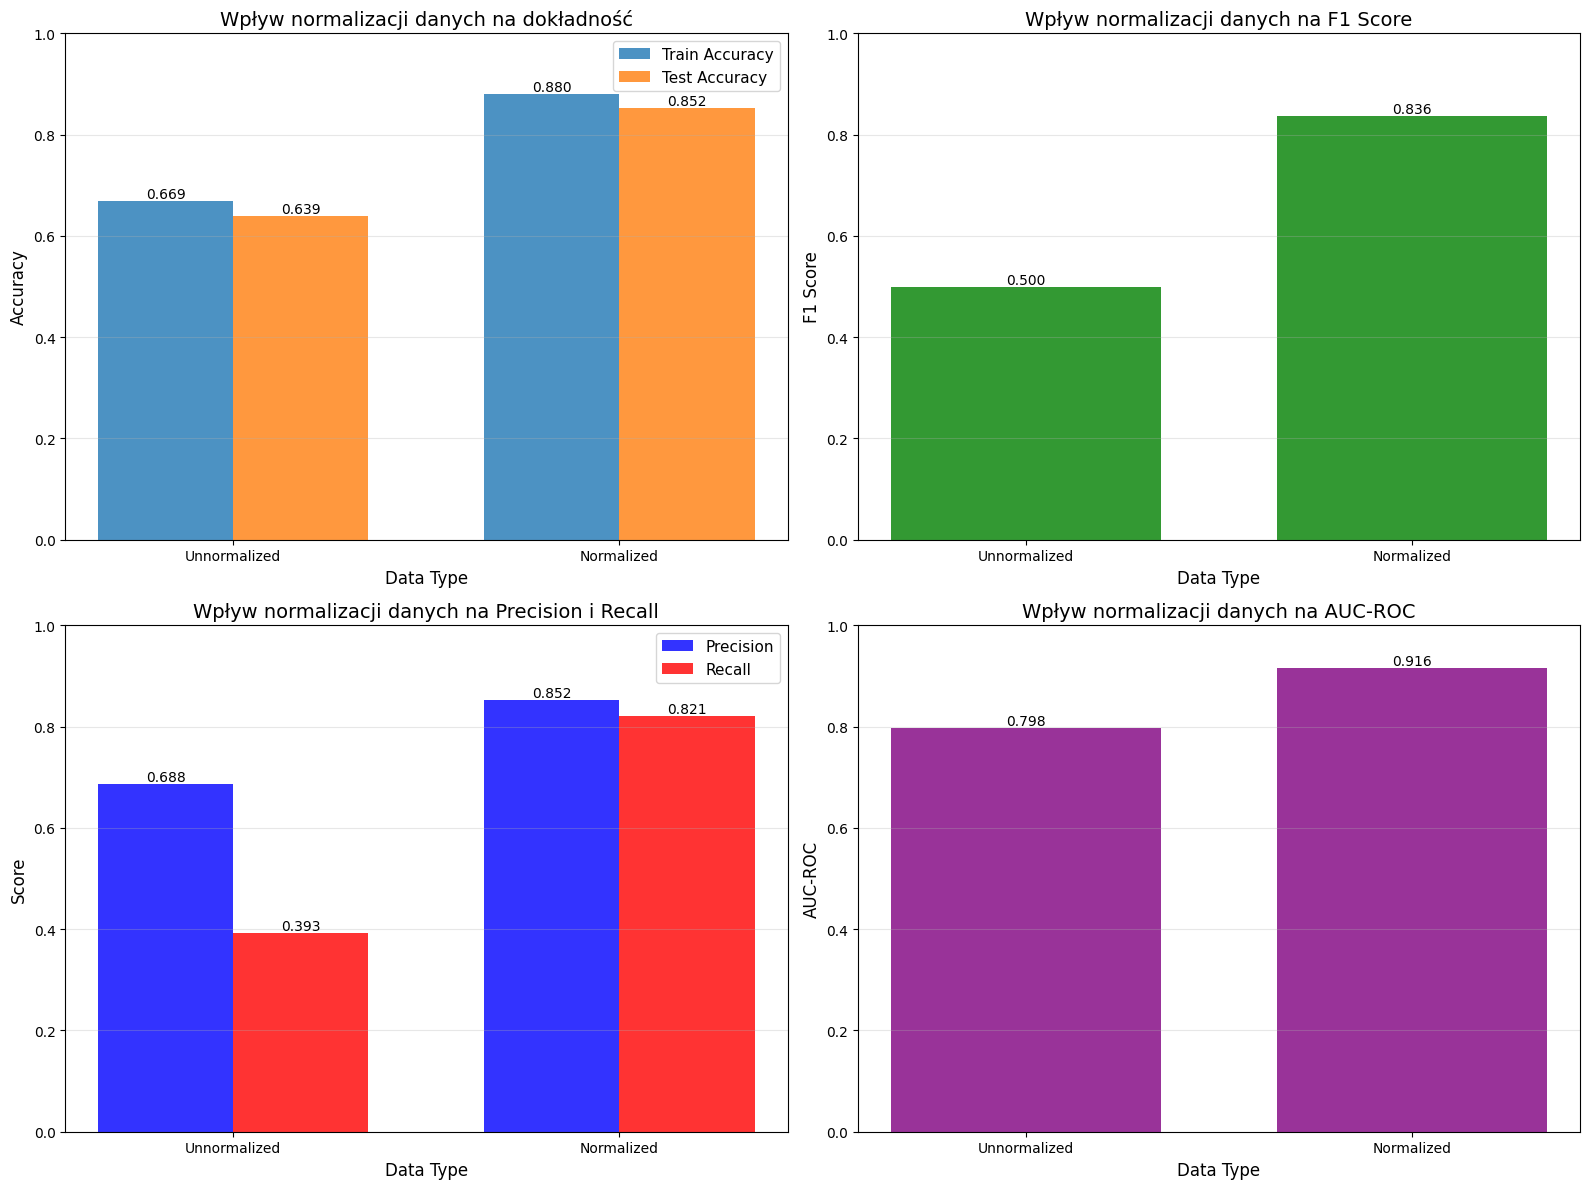

In [150]:
# Wizualizacja porównania normalizacji
plot_metrics_bar(
    norm_stats,
    category_column='data_type',
    title_prefix='Wpływ normalizacji danych',
    x_label='Data Type'
)


Unnormalized:
Precision: 0.6875
Recall: 0.3929
F1-Score: 0.5000
AUC-ROC: 0.7976
Confusion Matrix:
[[28  5]
 [17 11]]

Normalized:
Precision: 0.8519
Recall: 0.8214
F1-Score: 0.8364
AUC-ROC: 0.9156
Confusion Matrix:
[[29  4]
 [ 5 23]]


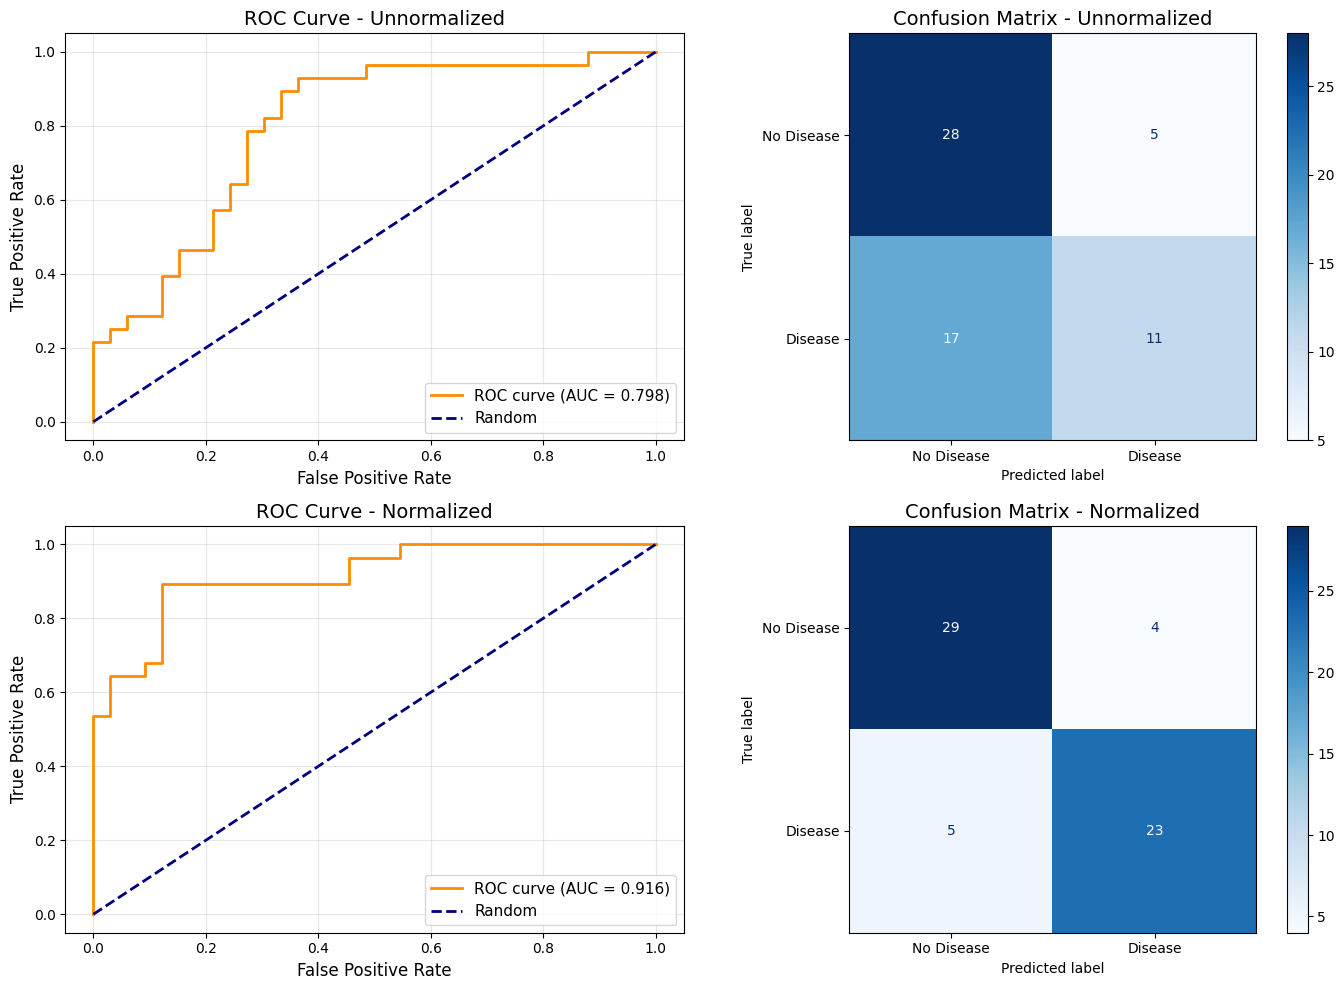

In [151]:
# Confusion Matrix dla porównania normalizacji
# Przygotuj modele do porównania
models_data = []

for norm_flag in [False, True]:
    # Trenuj model
    np.random.seed(seed)
    
    if norm_flag:
        Xtr, Xte = X_train_norm, X_test_norm
        label = "Normalized"
    else:
        Xtr, Xte = X_train_raw, X_test_raw
        label = "Unnormalized"
    
    model = NeuralNetwork([
        Layer(input_dim, 32, ReLU(), init_std=0.01),
        Layer(32, 1, Sigmoid(), init_std=0.01),
    ])
    train_and_evaluate(model, Xtr, y_train, Xte, y_test, epochs=2000, learning_rate=0.01, verbose=False)
    
    models_data.append({
        'model': model,
        'X_test': Xte,
        'label': label
    })

# Wizualizacja porównawcza
plot_comparison_roc_and_cm(models_data, y_test)

## 5. Wpływ liczby warstw

Testujemy różną liczbę warstw ukrytych: [1, 2, 3, 4]

In [152]:
# Test różnej liczby warstw
num_layers_list = [1, 2, 3, 4]

results = []

print("Testing different number of layers...")
for nl in num_layers_list:
    np.random.seed(seed)
    
    # Budowanie warstw
    layers = []
    
    if nl == 1:
        # 1 warstwa ukryta
        layers.append(Layer(input_dim, 32, ReLU(), init_std=0.01))
    elif nl == 2:
        # 2 warstwy ukryte
        layers.append(Layer(input_dim, 32, ReLU(), init_std=0.01))
        layers.append(Layer(32, 16, ReLU(), init_std=0.01))
    elif nl == 3:
        # 3 warstwy ukryte
        layers.append(Layer(input_dim, 64, ReLU(), init_std=0.01))
        layers.append(Layer(64, 32, ReLU(), init_std=0.01))
        layers.append(Layer(32, 16, ReLU(), init_std=0.01))
    else:  # nl == 4
        # 4 warstwy ukryte
        layers.append(Layer(input_dim, 64, ReLU(), init_std=0.01))
        layers.append(Layer(64, 32, ReLU(), init_std=0.01))
        layers.append(Layer(32, 16, ReLU(), init_std=0.01))
        layers.append(Layer(16, 8, ReLU(), init_std=0.01))
    
    # Warstwa wyjściowa
    layers.append(Layer(layers[-1].output_size, 1, Sigmoid(), init_std=0.01))
    
    model = NeuralNetwork(layers)
    
    train_acc, test_acc = train_and_evaluate(
        model, X_train_norm, y_train, X_test_norm, y_test,
        epochs=5000, learning_rate=0.05, verbose=False
    )
    
    # Calculate additional metrics
    test_proba = model.forward(X_test_norm)
    test_preds = (test_proba > 0.5).astype(int)
    
    precision = precision_score(y_test, test_preds)
    recall = recall_score(y_test, test_preds)
    f1 = f1_score(y_test, test_preds)
    roc_auc = roc_auc_score(y_test, test_proba)
    
    results.append({
        'num_layers': nl,
        'train_acc': train_acc,
        'test_acc': test_acc,
        'precision': precision,
        'recall': recall,
        'f1_score': f1,
        'auc_roc': roc_auc
    })
    
    print(f"Layers: {nl} | Train: {train_acc:.4f} | Test: {test_acc:.4f} | F1: {f1:.4f} | AUC: {roc_auc:.4f}")

layers_stats = pd.DataFrame(results)
print("\n" + "="*60)
print(layers_stats.to_string(index=False))

Testing different number of layers...
Layers: 1 | Train: 0.9917 | Test: 0.7541 | F1: 0.7368 | AUC: 0.8680
Layers: 2 | Train: 0.9959 | Test: 0.7705 | F1: 0.7500 | AUC: 0.8485


/Users/czaja/PycharmProjects/sieci/venv/lib/python3.13/site-packages/sklearn/metrics/_classification.py:1731: UndefinedMetricWarning: Precision is ill-defined and being set to 0.0 due to no predicted samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, f"{metric.capitalize()} is", result.shape[0])


Layers: 3 | Train: 0.5413 | Test: 0.5410 | F1: 0.0000 | AUC: 0.8983
Layers: 4 | Train: 0.5413 | Test: 0.5410 | F1: 0.0000 | AUC: 0.7100

 num_layers  train_acc  test_acc  precision  recall  f1_score  auc_roc
          1   0.991736  0.754098   0.724138    0.75  0.736842 0.867965
          2   0.995868  0.770492   0.750000    0.75  0.750000 0.848485
          3   0.541322  0.540984   0.000000    0.00  0.000000 0.898268
          4   0.541322  0.540984   0.000000    0.00  0.000000 0.709957


/Users/czaja/PycharmProjects/sieci/venv/lib/python3.13/site-packages/sklearn/metrics/_classification.py:1731: UndefinedMetricWarning: Precision is ill-defined and being set to 0.0 due to no predicted samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, f"{metric.capitalize()} is", result.shape[0])


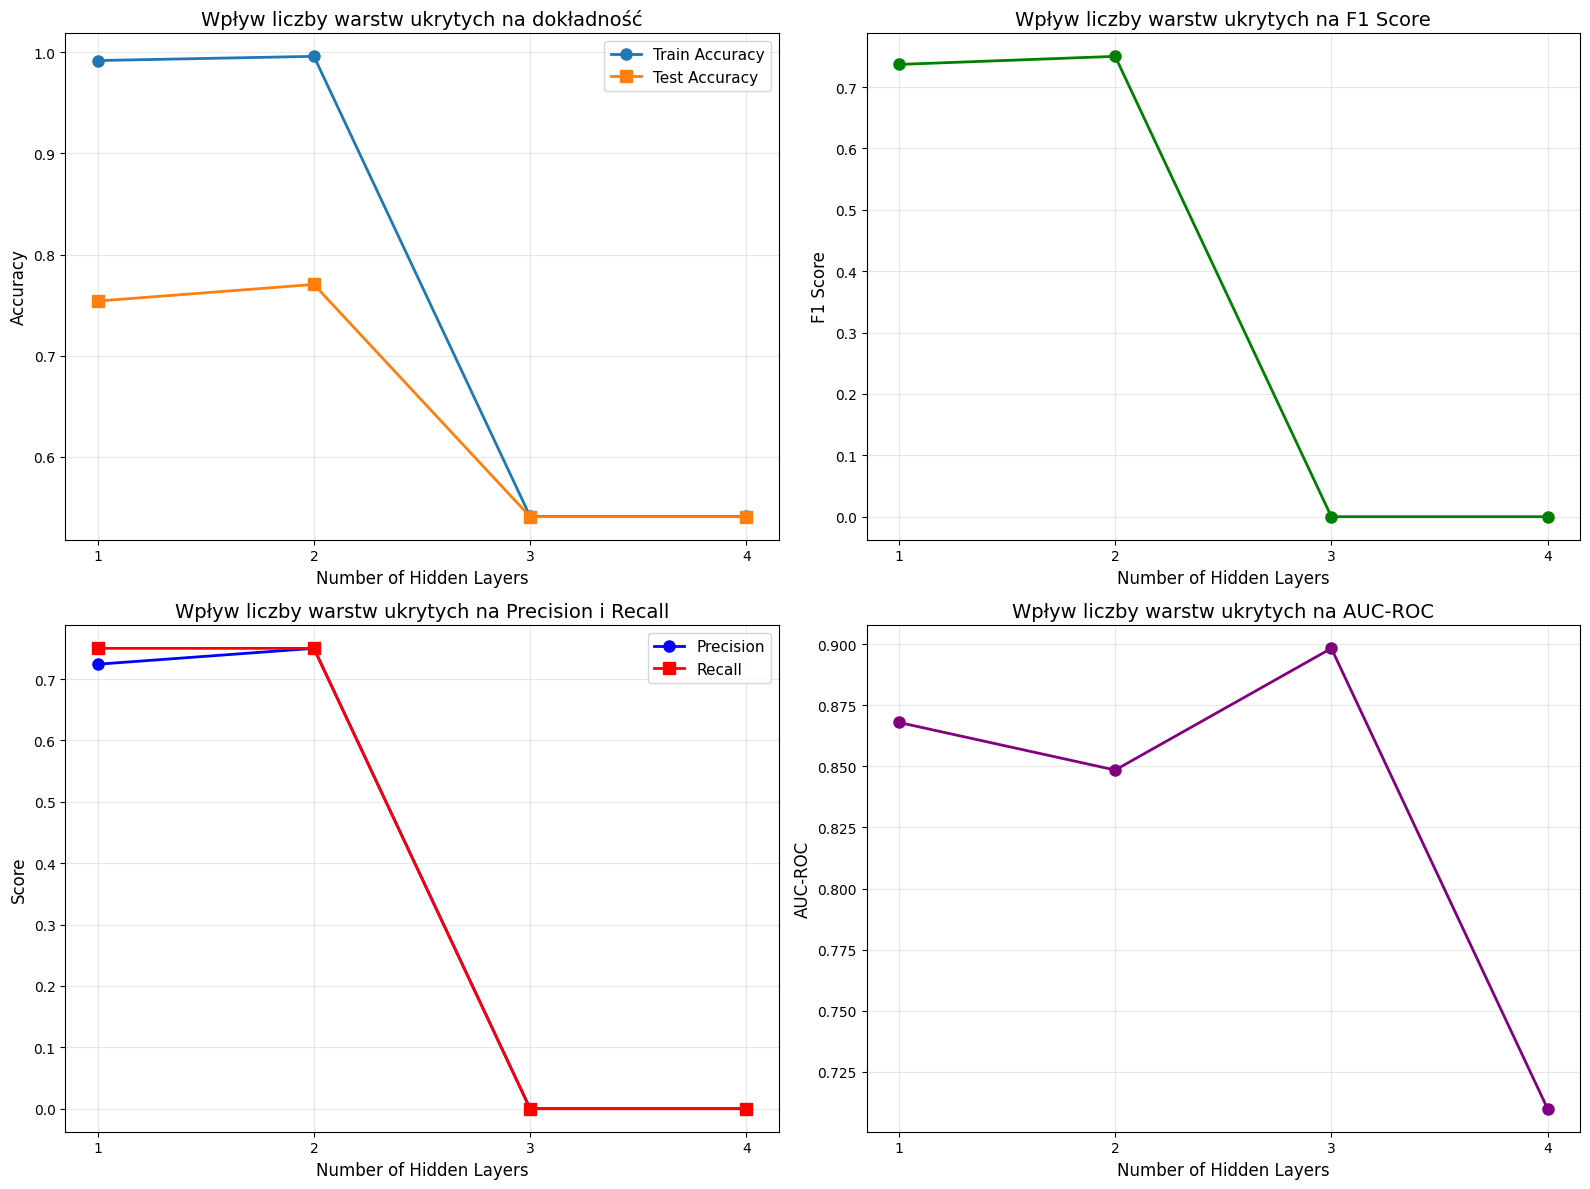

In [153]:
# Wizualizacja wyników dla liczby warstw
# Dla liczby warstw używamy standardowych ticków zamiast log scale
fig, axes = plt.subplots(2, 2, figsize=(16, 12))

# Accuracy
ax = axes[0, 0]
ax.plot(layers_stats['num_layers'], layers_stats['train_acc'], 'o-', label='Train Accuracy', linewidth=2, markersize=8)
ax.plot(layers_stats['num_layers'], layers_stats['test_acc'], 's-', label='Test Accuracy', linewidth=2, markersize=8)
ax.set_xlabel('Number of Hidden Layers', fontsize=12)
ax.set_ylabel('Accuracy', fontsize=12)
ax.set_title('Wpływ liczby warstw ukrytych na dokładność', fontsize=14)
ax.legend(fontsize=11)
ax.grid(True, alpha=0.3)
ax.set_xticks(layers_stats['num_layers'])

# F1 Score
ax = axes[0, 1]
ax.plot(layers_stats['num_layers'], layers_stats['f1_score'], 'o-', color='green', linewidth=2, markersize=8)
ax.set_xlabel('Number of Hidden Layers', fontsize=12)
ax.set_ylabel('F1 Score', fontsize=12)
ax.set_title('Wpływ liczby warstw ukrytych na F1 Score', fontsize=14)
ax.grid(True, alpha=0.3)
ax.set_xticks(layers_stats['num_layers'])

# Precision and Recall
ax = axes[1, 0]
ax.plot(layers_stats['num_layers'], layers_stats['precision'], 'o-', label='Precision', linewidth=2, markersize=8, color='blue')
ax.plot(layers_stats['num_layers'], layers_stats['recall'], 's-', label='Recall', linewidth=2, markersize=8, color='red')
ax.set_xlabel('Number of Hidden Layers', fontsize=12)
ax.set_ylabel('Score', fontsize=12)
ax.set_title('Wpływ liczby warstw ukrytych na Precision i Recall', fontsize=14)
ax.legend(fontsize=11)
ax.grid(True, alpha=0.3)
ax.set_xticks(layers_stats['num_layers'])

# AUC-ROC
ax = axes[1, 1]
ax.plot(layers_stats['num_layers'], layers_stats['auc_roc'], 'o-', color='purple', linewidth=2, markersize=8)
ax.set_xlabel('Number of Hidden Layers', fontsize=12)
ax.set_ylabel('AUC-ROC', fontsize=12)
ax.set_title('Wpływ liczby warstw ukrytych na AUC-ROC', fontsize=14)
ax.grid(True, alpha=0.3)
ax.set_xticks(layers_stats['num_layers'])

plt.tight_layout()
plt.show()

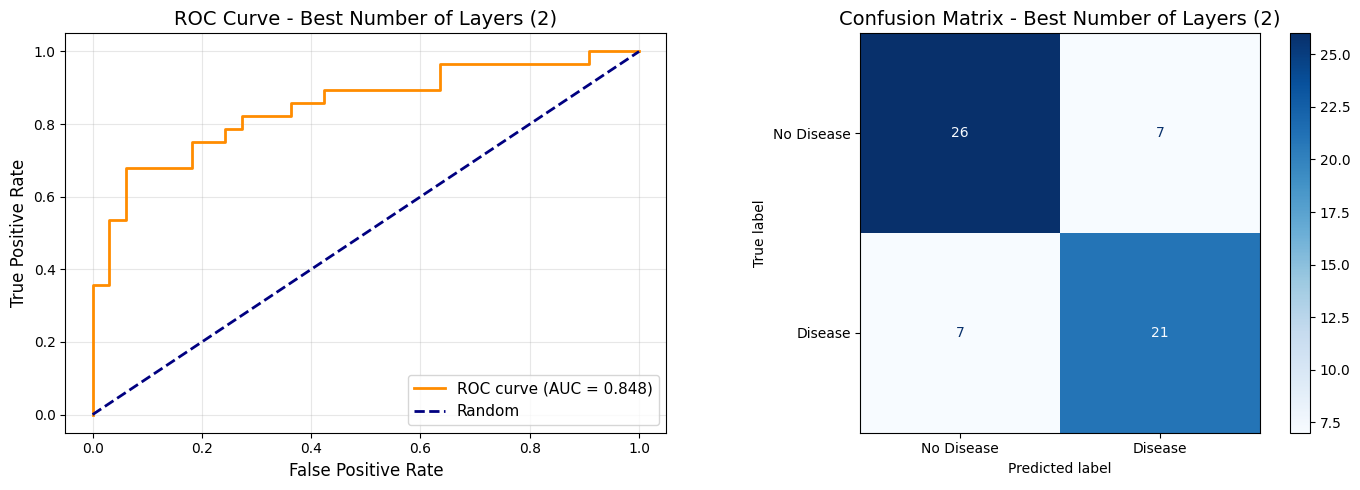


Best configuration: 2 layers
Precision: 0.7500
Recall: 0.7500
F1-Score: 0.7500
AUC-ROC: 0.8485

Confusion Matrix:
[[26  7]
 [ 7 21]]


(0.75,
 0.75,
 0.75,
 0.8484848484848485,
 array([[26,  7],
        [ 7, 21]]))

In [154]:
# Confusion Matrix dla najlepszego modelu w sekcji 5
# Znajdź najlepszy model
best_idx = layers_stats['test_acc'].idxmax()
best_layers = layers_stats.loc[best_idx, 'num_layers']

# Trenuj najlepszy model ponownie
np.random.seed(seed)

# Budowanie warstw
layers = []
nl = int(best_layers)

if nl == 1:
    layers.append(Layer(input_dim, 32, ReLU(), init_std=0.01))
elif nl == 2:
    layers.append(Layer(input_dim, 32, ReLU(), init_std=0.01))
    layers.append(Layer(32, 16, ReLU(), init_std=0.01))
elif nl == 3:
    layers.append(Layer(input_dim, 64, ReLU(), init_std=0.01))
    layers.append(Layer(64, 32, ReLU(), init_std=0.01))
    layers.append(Layer(32, 16, ReLU(), init_std=0.01))
else:  # nl == 4
    layers.append(Layer(input_dim, 64, ReLU(), init_std=0.01))
    layers.append(Layer(64, 32, ReLU(), init_std=0.01))
    layers.append(Layer(32, 16, ReLU(), init_std=0.01))
    layers.append(Layer(16, 8, ReLU(), init_std=0.01))

layers.append(Layer(layers[-1].output_size, 1, Sigmoid(), init_std=0.01))
model = NeuralNetwork(layers)

train_and_evaluate(model, X_train_norm, y_train, X_test_norm, y_test, epochs=5000, learning_rate=0.05, verbose=False)

# Predykcje
test_proba = model.forward(X_test_norm)
test_preds = (test_proba > 0.5).astype(int)

# Wizualizacja i metryki
plot_confusion_matrix_and_roc(
    y_test, test_proba, test_preds,
    title=f'Best Number of Layers ({nl})',
    config_text=f'{nl} layers'
)

## Wnioski

Na podstawie przeprowadzonych eksperymentów można wyciągnąć następujące wnioski:

### 1. Wymiarowość warstwy ukrytej
- Większe warstwy ukryte (32-64 neuronów) zazwyczaj dają lepsze wyniki niż małe (4-8)
- Zbyt duże warstwy (128+) mogą prowadzić do przeuczenia lub wolniej zbiegają
- Optymalna wymiarowość zależy od złożoności problemu

### 2. Współczynnik uczenia
- Zbyt małe learning rate (0.001) - wolna zbieżność
- Zbyt duże learning rate (0.5) - niestabilne uczenie
- Optymalne wartości: 0.01 - 0.05

### 3. Inicjalizacja wag
- Bardzo małe std (0.001) - powolne uczenie
- Bardzo duże std (1.0) - niestabilność
- Optymalne: 0.01 - 0.1

### 4. Normalizacja danych
- **Normalizacja znacząco poprawia wyniki!**
- Nieznormalizowane dane mogą powodować problemy ze zbieżnością
- Normalizacja jest kluczowa dla sieci neuronowych

### 5. Liczba warstw
- Dla heart disease dataset optymalna to zazwyczaj 1-2 warstwy ukryte